In [3]:
import glob
import tensorflow as tf

In [5]:
images_folder = '../images'

Shape of the image: (1458, 1920, 3)


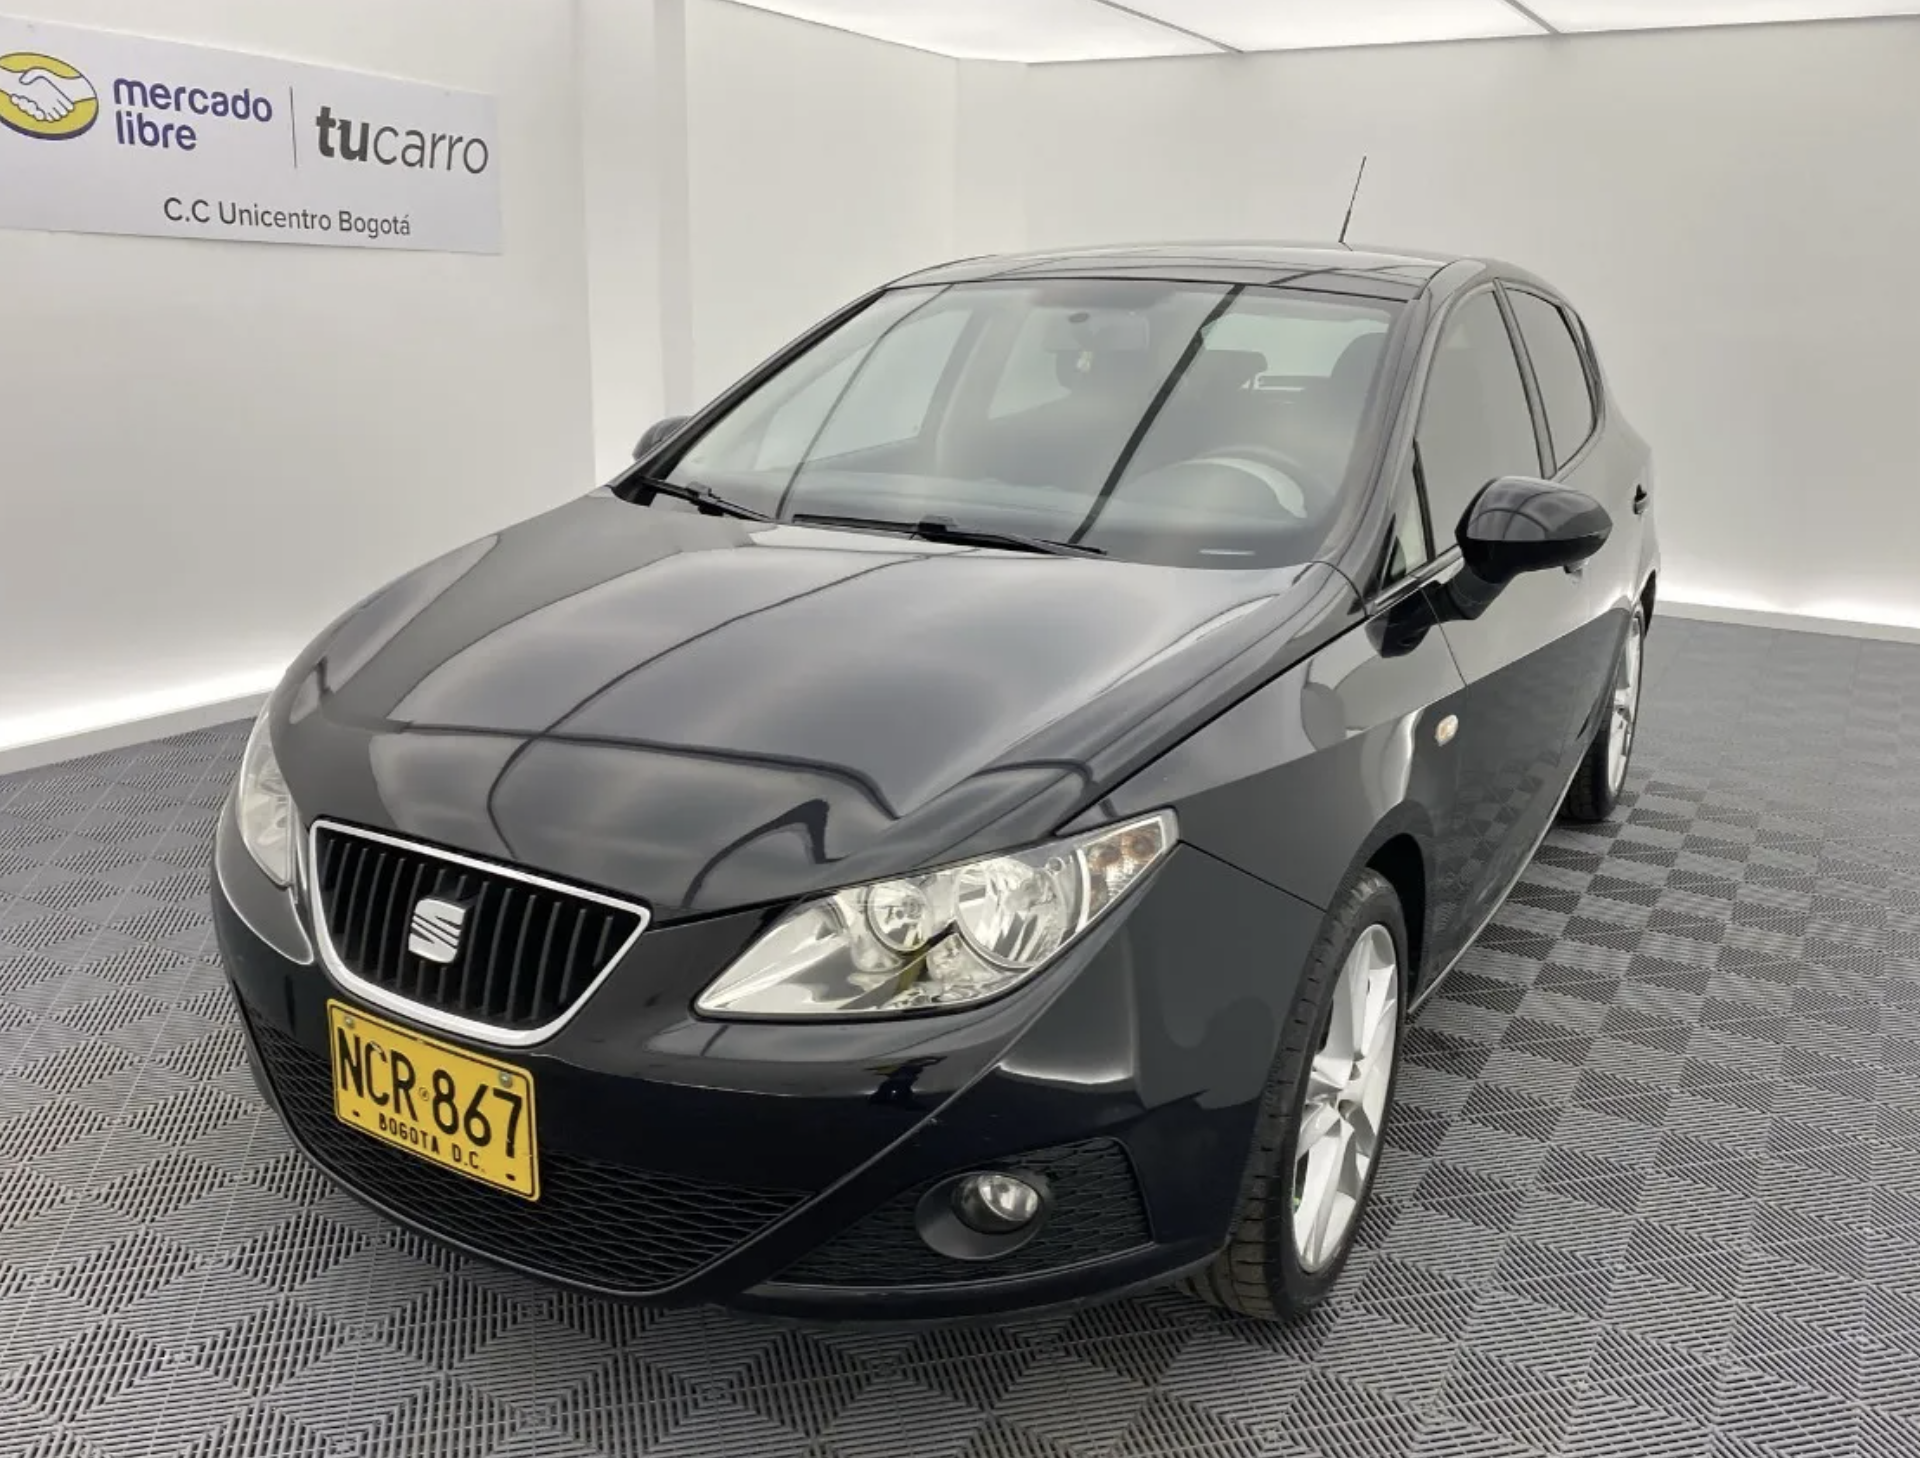

In [167]:
# test load image
image_files = glob.glob(images_folder + '/*/*.png')
image = image_files[0]

pil_image = tf.keras.preprocessing.image.load_img(image)
tf_image = tf.keras.preprocessing.image.img_to_array(pil_image)
print(f'Shape of the image: {tf_image.shape}')
pil_image

The image has a big resolution (1920 x 1458 x 3) which needs to be reduced for computational purposes.

In [168]:
# callback
class AccReached(tf.keras.callbacks.Callback):
  def __init__(self):
    pass
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy') > 0.8):
      print("\nReached 80% accuracy so cancelling training!")
      self.model.stop_training = True


In [6]:
# import images
train_images = tf.keras.preprocessing.image_dataset_from_directory(
  images_folder,
  labels='inferred',
  image_size=(256, 256),
  batch_size=16,
  shuffle=True,
)

Found 102 files belonging to 3 classes.
Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-11-01 17:33:11.569832: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-11-01 17:33:11.570570: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [170]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(256, 256, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

In [171]:
model.compile(
  loss='sparse_categorical_crossentropy',
  optimizer=tf.optimizers.SGD(learning_rate=0.001),
  metrics=['accuracy'],
)

In [172]:
history = model.fit(
  train_images.repeat(),
  steps_per_epoch=10,
  epochs=100,
  verbose=1,
  callbacks=[AccReached()],
)

Epoch 1/100


2022-11-01 15:29:46.518629: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - 3s 209ms/step - loss: 127.0124 - accuracy: 0.3600
Epoch 2/100
10/10 [==============================] - 2s 167ms/step - loss: 1.1637 - accuracy: 0.3667
Epoch 3/100
10/10 [==============================] - 2s 253ms/step - loss: 1.0496 - accuracy: 0.3714
Epoch 4/100
10/10 [==============================] - 2s 166ms/step - loss: 0.9778 - accuracy: 0.4533
Epoch 5/100
10/10 [==============================] - 2s 248ms/step - loss: 0.9033 - accuracy: 0.5286
Epoch 6/100
10/10 [==============================] - 2s 163ms/step - loss: 0.7856 - accuracy: 0.6933
Epoch 7/100
10/10 [==============================] - 1s 157ms/step - loss: 0.7172 - accuracy: 0.7000
Epoch 8/100
10/10 [==============================] - ETA: 0s - loss: 0.5586 - accuracy: 0.8000
Reached 80% accuracy so cancelling training!
10/10 [==============================] - 2s 172ms/step - loss: 0.5586 - accuracy: 0.8000


1/1 [==============================] - 0s 29ms/step
Model prediction: back


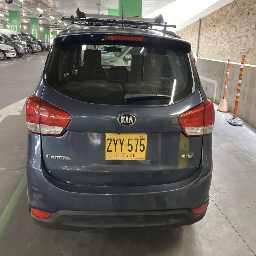

In [175]:
# prediction
new_image = image_files[50]
pil_image = tf.keras.preprocessing.image.load_img(new_image, target_size=(256, 256))
tf_image = tf.keras.preprocessing.image.img_to_array(pil_image)
probs = model.predict(tf_image.reshape(1, 256, 256, 3))
print(f'Model prediction: {train_images.class_names[probs.argmax()]}')
pil_image

In [176]:
# save the model
model.save('labeling_model.h5')

In [7]:
train_images.class_names

['back', 'front', 'neither']